# Make plots for paper

## Import relevant modules

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from astropy.io import fits
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from copy import copy
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
from scripts.ned_calculator import NedCalculator

In [6]:
def read_fits_summary(fitsfile):
    
    hdu = fits.open(fitsfile)

    age_grid = hdu['age_grid'].data
    weights = hdu['pp_weights'].data.reshape(hdu['reg_dim'].data)

    name = hdu[0].header['name']
    z = hdu[0].header['z']
    hdu.close()
    del hdu

    wei1 = weights.sum(axis=1)
    wei1/=wei1.sum()

    wei1_rev = copy(wei1[::-1])

    ages = age_grid[:,0]

    weiplot = np.cumsum(wei1_rev)

    nedcalc = NedCalculator(z)
    univ_age = nedcalc.zage_Gyr

    ages1 = univ_age - ages

    agesplot = np.concatenate([np.array([univ_age]), ages1, np.array([0.])])
    weiplot = np.concatenate([np.array([0.]), weiplot, np.array([weiplot[-1]])])

    agesplot = copy(agesplot[::-1])
    
    return name,z,agesplot,weiplot,univ_age

In [12]:
df = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300,
    "font.size": 15,
})

## Figure 7

In [14]:
lam_range_temp = [1000, 1e4]
vel = 0                 # Spectrum is de-redshifted --> starting guess is zero
start = [vel, 200.]     # (km/s), starting guess for [V, sigma]
tie_balmer = True
limit_doublets = True
c = 299792.458  # speed of light in km/s
regul_err = 0.1 # Large regularization error
vel = 0   # eq.(8) of Cappellari (2017)
moments = [4, 2, 2]
gas_reddening = 0 if tie_balmer else None

In [15]:
def make_ppxf_plot(pp_curr, sps_curr, weights_curr, textstr, path, colour='afmhot'):
    plt.close('all')

    # Create a new figure
    fig = plt.figure(figsize=(25, 10))
    
    # Create GridSpec
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')
    hor_align = 0.92
    ver_align = 0.21
    
    # First subplot - spectrum
    ax1 = fig.add_subplot(gs[0])
    
    # Let pp_curr handle its own plotting
    pp_curr.plot()
    
    # After plotting, modify the x-axis label to use Angstroms
    ax1.set_xlabel(r'Wavelength (\AA)', fontsize=16)
    ax1.grid(False)  # Remove grid
    ax1.text(hor_align, ver_align, textstr, transform=ax1.transAxes, fontsize=30,
            verticalalignment='top', bbox=props, ha='center', linespacing=1.5)
    
    # Convert x-axis from microns to Angstroms if needed
    # Check if current ticks are in microns by seeing if they're all < 10
    current_ticks = ax1.get_xticks()
    if all(tick < 10 for tick in current_ticks):
        # Current ticks are in microns, convert to Angstroms
        ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])
    
    # Second subplot - weights
    ax2 = fig.add_subplot(gs[1])
    sps_curr.plot(weights_curr, cmap=colour)
    ax2.set_xlabel('')
    ax2.set_title('')
    ax2.grid(False)  # Remove grid
    
    # Make sure x-tick labels are visible
    plt.setp(ax1.get_xticklabels(), visible=True)
    plt.setp(ax2.get_xticklabels(), visible=True)
    
    # Final adjustments
    plt.tight_layout()
    fig.align_ylabels([ax1])
    
    # Save the figure
    plt.savefig(path, bbox_inches='tight', dpi=300)

In [16]:
row = df[df['filename']=="data/stacked_fits/stacked_REGRESSION_0.fits"].iloc[0]
hdu = fits.open('../data/stacked_fits/stacked_REGRESSION_0.fits', ignore_missing_simple=True)

t = hdu['COADD'].data

galaxy1 = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = np.log(t['wave'])
# ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
wave1 = np.exp(ln_lam_gal)
print(wave1)

redshift = 0
sigma = row['vel_disp_avg']
alpha = row['alpha']
print("alpha",alpha)
alpha = int(alpha)/10

if alpha < 0:
    alpha = '0'
elif alpha > 0.4:
    alpha = '4'
else:
    alpha = str(int(alpha*10))
print("alpha",alpha)

wave1 = wave1/(1 + redshift)  # Compute wave in the galaxy rest frame
galaxy1 = galaxy1[(wave1 > 3600) & (wave1 < 6500)]
wave1 = wave1[(wave1 > 3600) & (wave1 < 6500)]

wave1 *= np.median(util.vac_to_air(wave1)/wave1)

noise = np.full_like(galaxy1, 0.0163)  # Assume constant noise per pixel here

d_ln_lam = np.log(wave1[-1]/wave1[0])/(wave1.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

filename = f'../data/MILES_SSP/alpha{alpha}.npz'
print("filename",filename)

sps1 = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.35])

reg_dim = sps1.templates.shape[1:]
stars_templates = sps1.templates.reshape(sps1.templates.shape[0], -1)

lam_range_gal = np.array([np.min(wave1), np.max(wave1)])

gas_templates, gas_names, line_wave = util.emission_lines(
sps1.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
limit_doublets=limit_doublets)

templates = np.column_stack([stars_templates, gas_templates])

start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

start = [start, start, start]

pp = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
        degree=-1, mdegree=8, lam=wave1, lam_temp=sps1.lam_temp,
        regul=1/regul_err, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names,
        gas_reddening=gas_reddening, quiet=True)

noise = noise*np.sqrt(pp.chi2)

pp_high = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave1, lam_temp=sps1.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, clean=True, quiet=True)

weights_high = pp_high.weights[~gas_component]                # Exclude weights of the gas templates
weights_high = weights_high.reshape(reg_dim)/weights_high.sum() 

print("chi^2=",pp_high.chi2)

[3659.77651367 3660.45463573 3661.13288345 ... 7434.06523061 7435.44269277
 7436.82041016]
alpha 0.3
alpha 0
filename ../data/MILES_SSP/alpha0.npz
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
chi^2= 0.7828466306014724


/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_9861/2120721124.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])


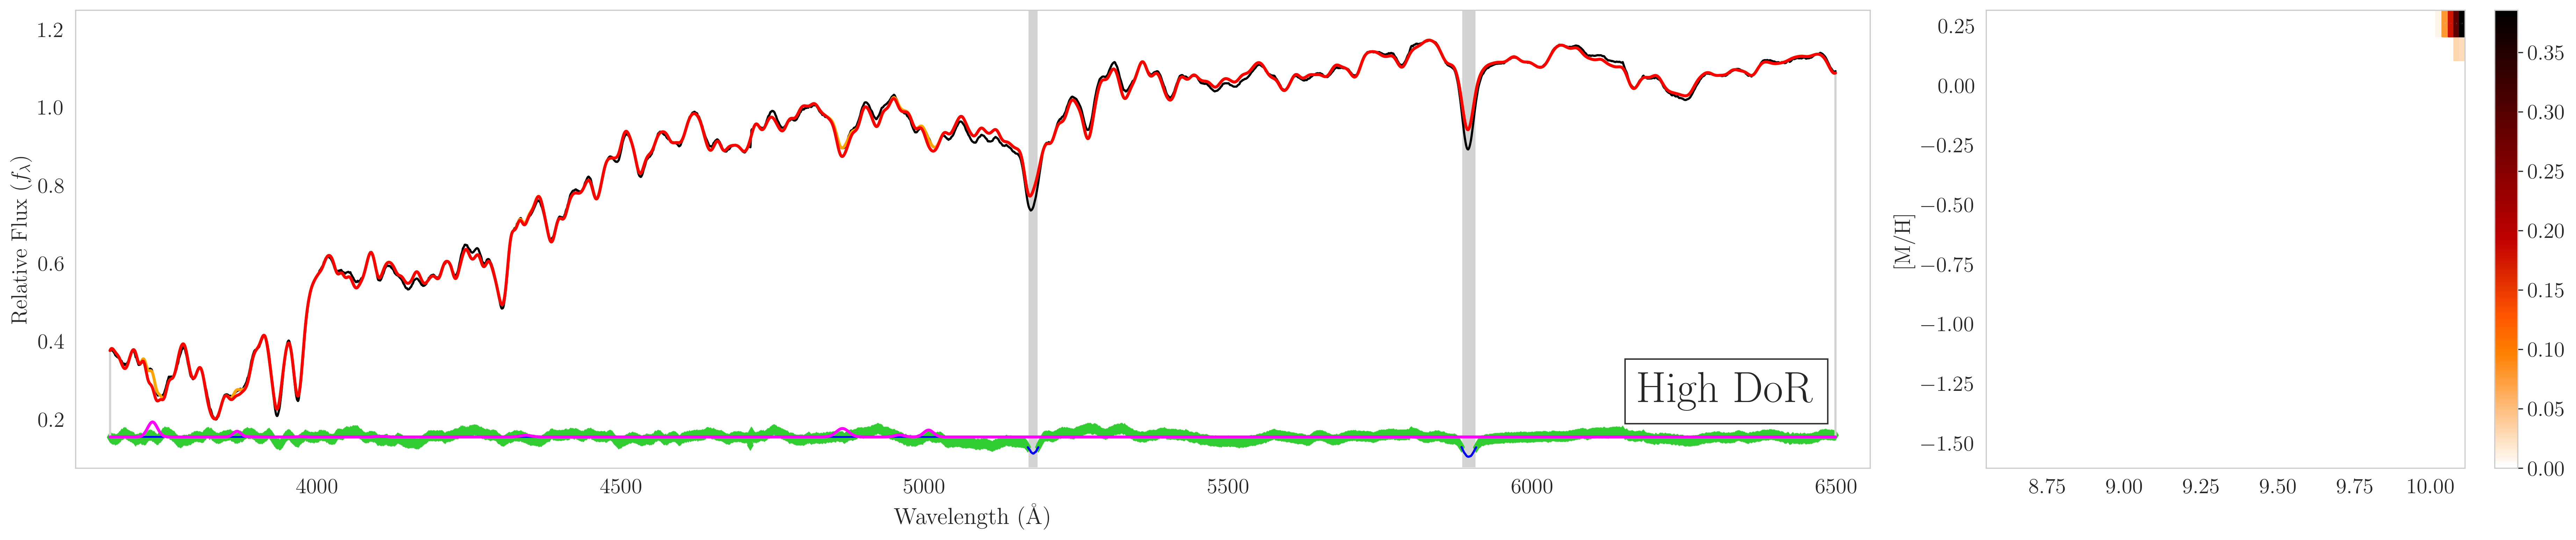

In [17]:
pp_curr = pp_high
sps_curr = sps1
weights_curr = weights_high
textstr = 'High DoR'  # Change this text as needed
path = '../outputs/make_plots_output/stellar_pop_fit_high.pdf'

make_ppxf_plot(pp_curr, sps_curr, weights_curr, textstr, path, colour='gist_heat_r')

In [18]:
row = df[df['filename']=="data/stacked_fits/stacked_REGRESSION_2.fits"].iloc[0]
hdu = fits.open('../data/stacked_fits/stacked_REGRESSION_2.fits', ignore_missing_simple=True)

t = hdu['COADD'].data

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = np.log(t['wave'])
# ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
wave = np.exp(ln_lam_gal)

redshift = 0
sigma = row['vel_disp_avg']
alpha = row['alpha']
print("alpha",alpha)
alpha = int(alpha)/10

if alpha < 0:
    alpha = '0'
elif alpha > 0.4:
    alpha = '4'
else:
    alpha = str(int(alpha*10))
print("alpha",alpha)

wave = wave/(1 + redshift)  # Compute wave in the galaxy rest frame
galaxy = galaxy[(wave > 3600) & (wave < 6500)]
wave = wave[(wave > 3600) & (wave < 6500)]

wave *= np.median(util.vac_to_air(wave)/wave)

noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

filename = f'../data/MILES_SSP/alpha{alpha}.npz'
print("filename",filename)

sps2 = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.35])

reg_dim = sps2.templates.shape[1:]
stars_templates = sps2.templates.reshape(sps2.templates.shape[0], -1)

lam_range_gal = np.array([np.min(wave), np.max(wave)])

gas_templates, gas_names, line_wave = util.emission_lines(
sps2.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
limit_doublets=limit_doublets)

templates = np.column_stack([stars_templates, gas_templates])

start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

start = [start, start, start]

pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
        degree=-1, mdegree=8, lam=wave, lam_temp=sps2.lam_temp,
        regul=1/regul_err, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names,
        gas_reddening=gas_reddening, quiet=True)

noise = noise*np.sqrt(pp.chi2)

pp_low = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps2.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, clean=True, quiet=True)

weights_low = pp_low.weights[~gas_component]                # Exclude weights of the gas templates
weights_low = weights_low.reshape(reg_dim)/weights_low.sum()    # Normalized

alpha 0.2
alpha 0
filename ../data/MILES_SSP/alpha0.npz
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']


/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_9861/2120721124.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])


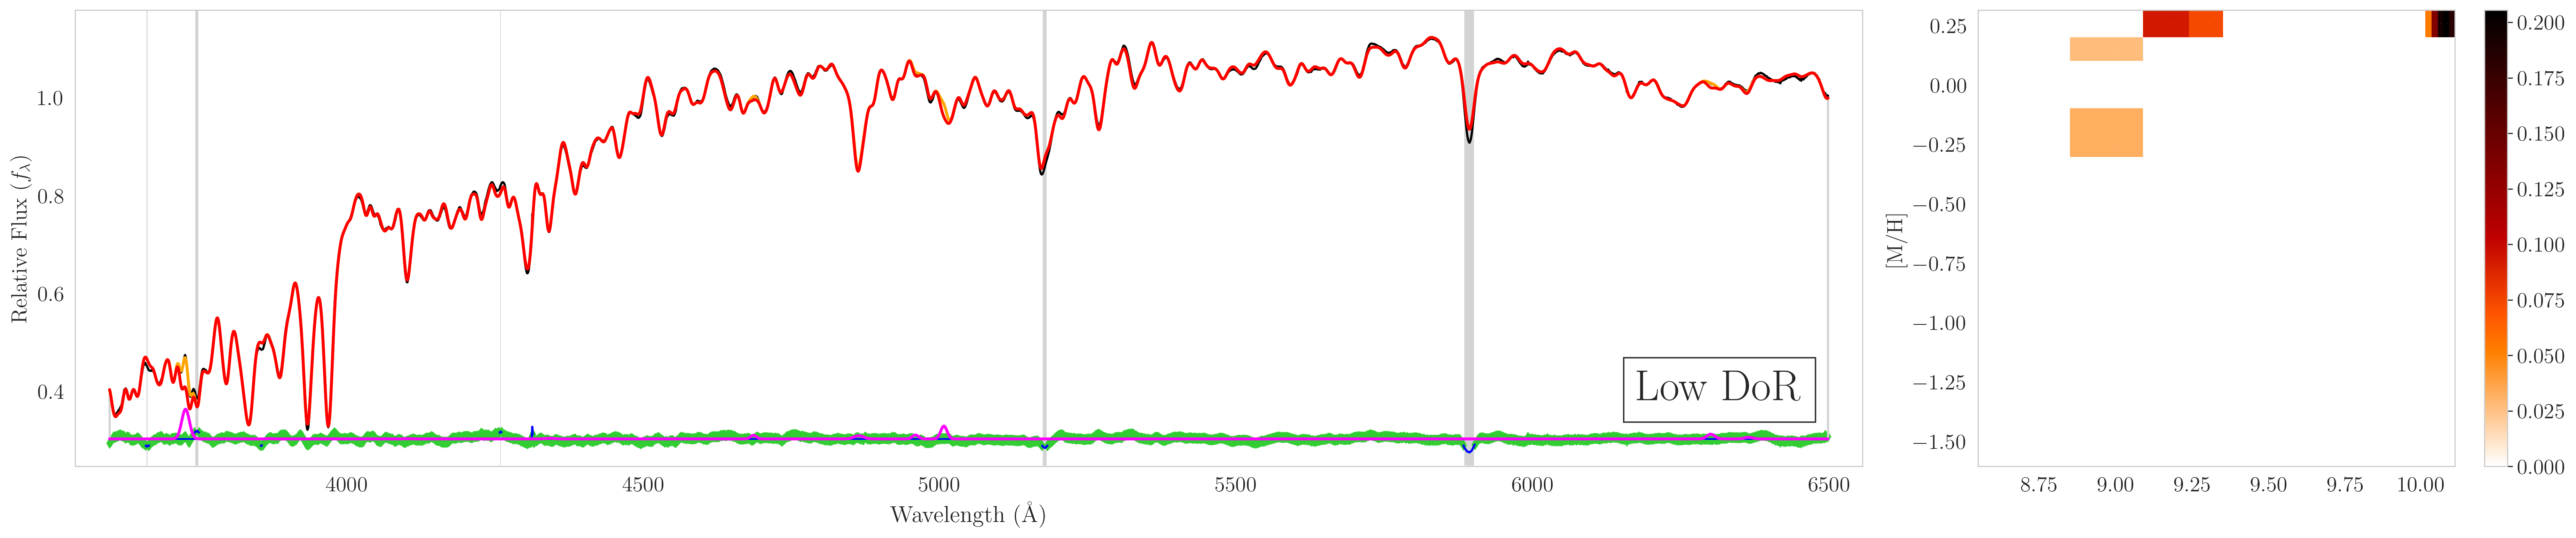

In [19]:
pp_curr = pp_low
sps_curr = sps2
weights_curr = weights_low
textstr = 'Low DoR'  # Change this text as needed
path = '../outputs/make_plots_output/stellar_pop_fit_low.pdf'

make_ppxf_plot(pp_curr, sps_curr, weights_curr, textstr, path, colour = 'gist_heat_r')


## Figure 7b

Normalizing spectra at wavelength 4799.68Å
High DoR flux at normalization: 0.9942
Low DoR flux at normalization: 1.0641
Normalization factor for Low DoR: 0.9343


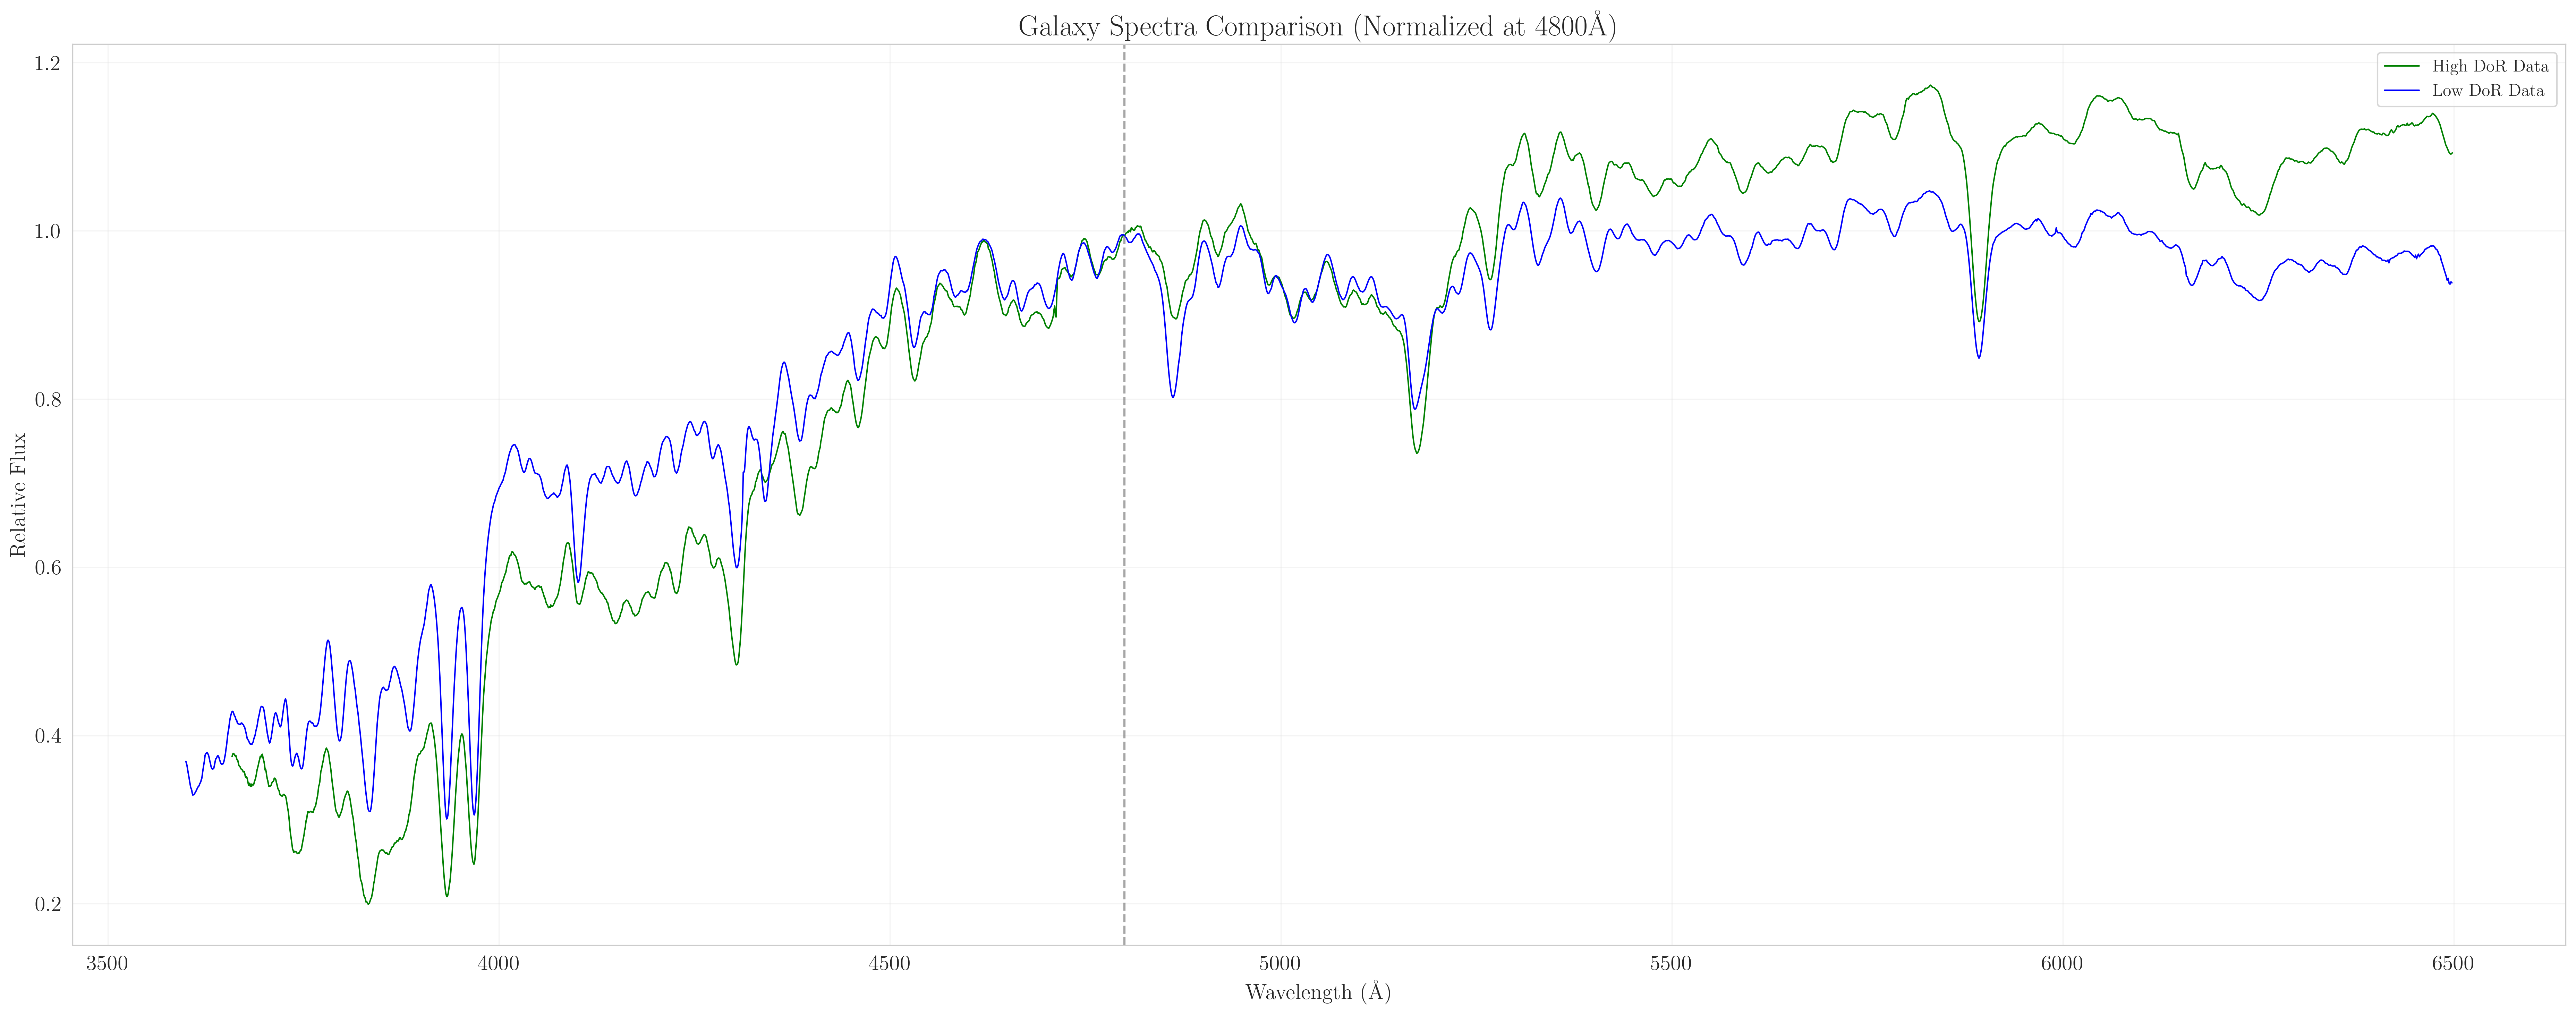

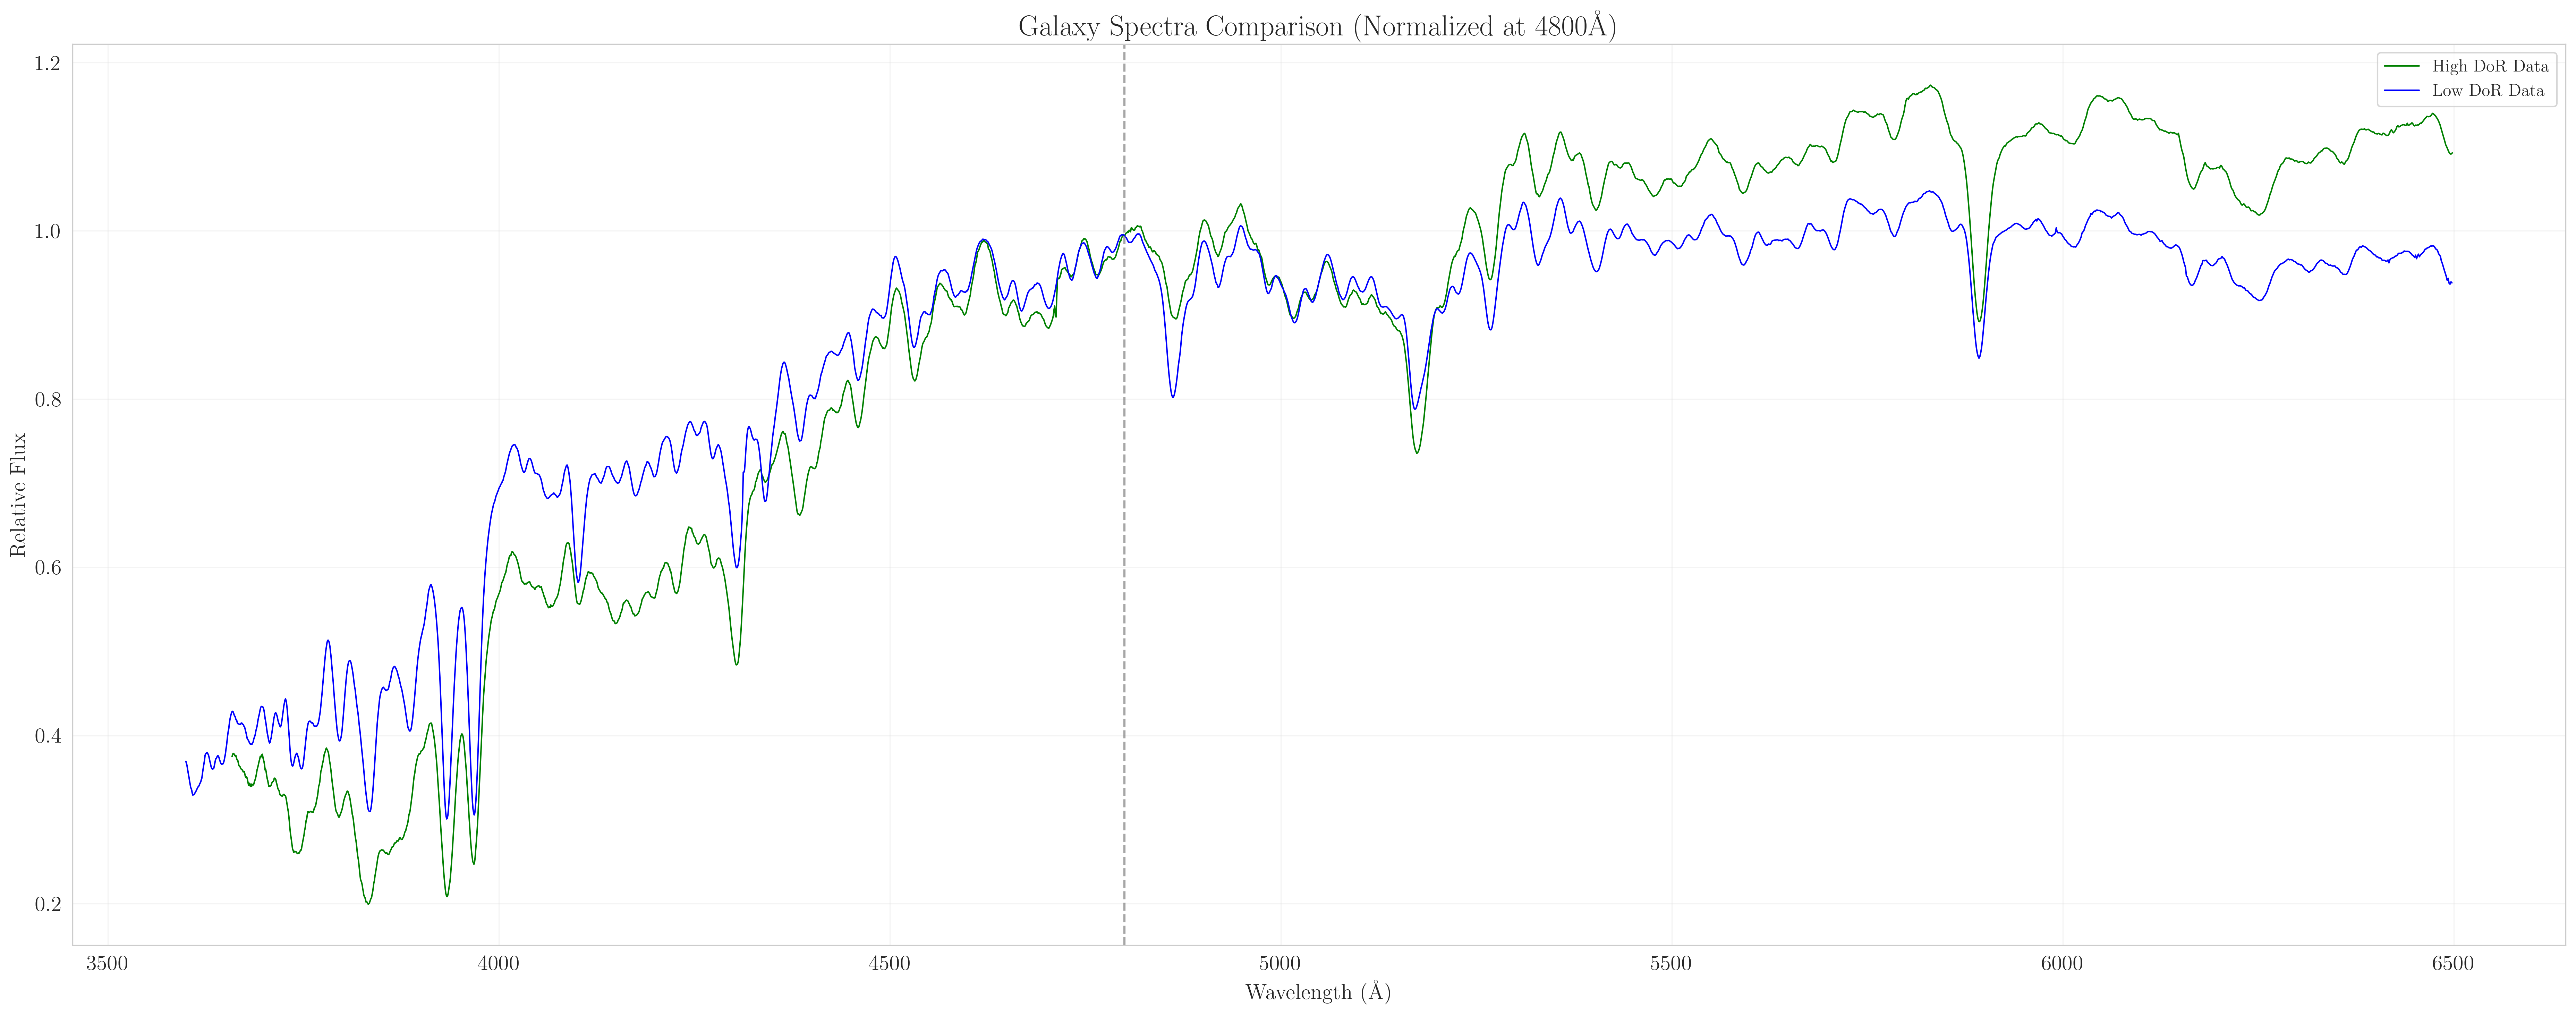

In [20]:
def make_ppxf_plots_overlaid(pp_high, pp_low, high_text="High DoR", low_text="Low DoR", 
                            y_offset=0.0, path="overlaid_spectra_plot.pdf", 
                            normalize_at_wavelength=4000.0):
    
    # Close all existing figures
    plt.close('all')
    
    # Create a new figure
    fig = plt.figure(figsize=(25, 10))
    
    # First, let the high DoR ppxf object plot itself (creates its own axes)
    pp_high.plot()
    
    # Get the current axes that ppxf.plot() created
    ax = plt.gca()
    
    # Get the data from both ppxf objects
    wave_high = pp_high.lam
    galaxy_high = pp_high.galaxy
    bestfit_high = pp_high.bestfit
    
    wave_low = pp_low.lam
    galaxy_low = pp_low.galaxy
    bestfit_low = pp_low.bestfit
    
    # Normalize at the specified wavelength
    if normalize_at_wavelength is not None:
        # Find the closest index to the normalization wavelength for both spectra
        idx_high = np.argmin(np.abs(wave_high - normalize_at_wavelength))
        idx_low = np.argmin(np.abs(wave_low - normalize_at_wavelength))
        
        # Get flux values at those wavelengths
        flux_high_at_norm = galaxy_high[idx_high]
        flux_low_at_norm = galaxy_low[idx_low]
        
        # Calculate normalization factors
        norm_factor_high = 1.0  # Keep high DoR spectrum as reference
        norm_factor_low = flux_high_at_norm / flux_low_at_norm
        
        # Apply normalization
        galaxy_high_norm = galaxy_high * norm_factor_high
        bestfit_high_norm = bestfit_high * norm_factor_high
        galaxy_low_norm = galaxy_low * norm_factor_low
        bestfit_low_norm = bestfit_low * norm_factor_low
        
        print(f"Normalizing spectra at wavelength {wave_high[idx_high]:.2f}Å")
        print(f"High DoR flux at normalization: {flux_high_at_norm:.4f}")
        print(f"Low DoR flux at normalization: {flux_low_at_norm:.4f}")
        print(f"Normalization factor for Low DoR: {norm_factor_low:.4f}")
    else:
        # If no normalization is requested, use original values
        galaxy_high_norm = galaxy_high
        bestfit_high_norm = bestfit_high
        galaxy_low_norm = galaxy_low
        bestfit_low_norm = bestfit_low
    
    # Clear the existing plot but keep the axes
    ax.clear()
    
    # Create a custom color scheme
    high_color = 'green'
    high_bestfit_color = 'red'
    
    low_color = 'blue'
    low_bestfit_color = 'green'
    
    # Plot high DoR data and best fit
    ax.plot(wave_high, galaxy_high_norm, color=high_color, lw=1, label=f'{high_text} Data')
    #ax.plot(wave_high, bestfit_high_norm, color=high_bestfit_color, lw=2, label=f'{high_text} Best Fit')
    
    # Plot low DoR data and best fit with the specified y-offset
    ax.plot(wave_low, galaxy_low_norm + y_offset, color=low_color, lw=1, label=f'{low_text} Data')
    #ax.plot(wave_low, bestfit_low_norm + y_offset, color=low_bestfit_color, lw=2, label=f'{low_text} Best Fit')
    
    # Add a vertical line at the normalization wavelength if specified
    if normalize_at_wavelength is not None:
        ax.axvline(x=normalize_at_wavelength, color='gray', linestyle='--', alpha=0.7)
    
    # Add a grid for reference
    ax.grid(True, alpha=0.2)
    
    # Add a legend with both spectra
    ax.legend(loc='upper right', fontsize=12)
    
    # Add title and labels
    title = f'Galaxy Spectra Comparison'
    if normalize_at_wavelength is not None:
        title += f' (Normalized at {normalize_at_wavelength}Å)'
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    ax.set_ylabel('Relative Flux', fontsize=15)
    
    # Final adjustments
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(path, bbox_inches='tight', dpi=300)
    
    return fig

# Usage with normalization at 4000Å
make_ppxf_plots_overlaid(
    pp_high, pp_low,
    high_text="High DoR", 
    low_text="Low DoR",
    y_offset=0.0,  # Adjust this value to control vertical separation
    path="../outputs/make_plots_output/overlaid_stellar_pop_comparison.pdf",
    normalize_at_wavelength=4800  # Normalize both spectra at 4000Å
)

## Figure 8

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_9861/806647966.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}" for tick in ax.get_yticks()])


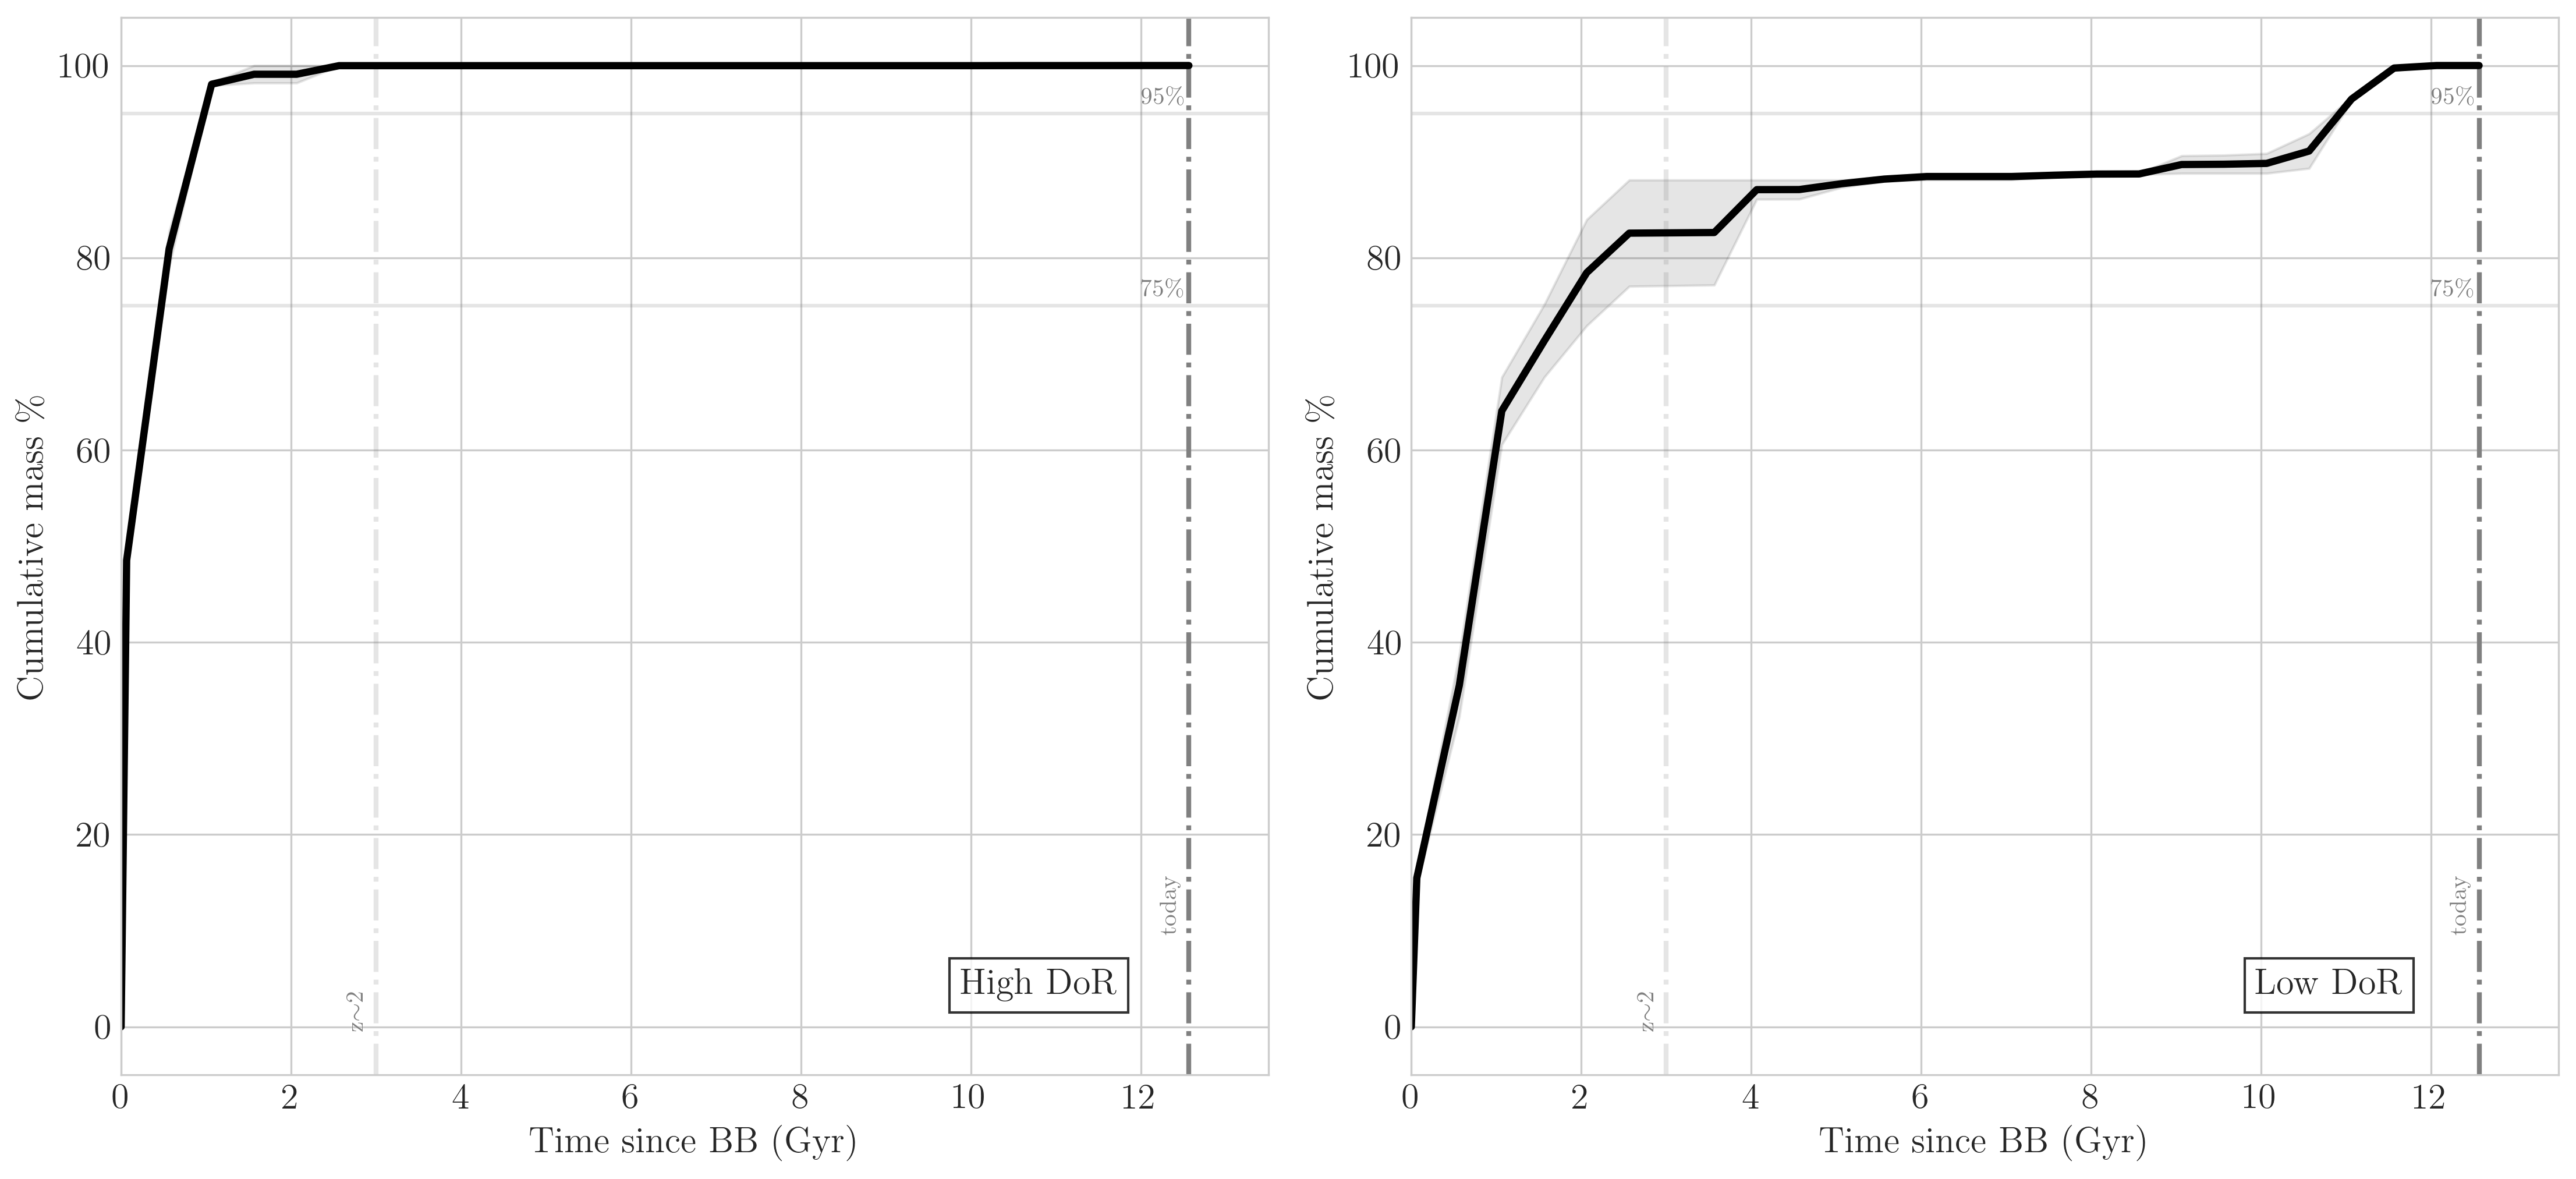

In [21]:

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')

# Create a smaller dataframe with just the two galaxies you want to plot
# Example: choose galaxies 0 and 2 from your stacked regression set
galaxy_ids = [0, 2]  # indices of the galaxies you want to plot
df_subset = pd.DataFrame({
    "filename": [f"data/stacked_fits/stacked_REGRESSION_{id}.fits" for id in galaxy_ids]
})

# Loop through just these two galaxies
for idx, (index, row) in enumerate(df_subset.iterrows()):
    # Get the file ID
    galaxy_id = galaxy_ids[idx]
    
    # Set up your file paths as in your original code
    fitsfile1 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_UNR.fits'
    fitsfile2 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_REGUL.fits'
    
    # Process the files exactly as in your original code
    name1, z1, agesplot1, weiplot1, univ_age1 = read_fits_summary(fitsfile1)
    name2, z2, agesplot2, weiplot2, univ_age2 = read_fits_summary(fitsfile2)

    masses = [weiplot1, weiplot2]
    mean_masses = np.mean(masses, axis=0)
    std_masses = np.std(masses, axis=0)

    # Plot using the appropriate subplot (index 0 or 1)
    ax = axs[idx]
    
    # The rest is the same as your original code, but using ax instead of axs[index%3,index//3]
    ax.set_xlim(0, 13.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Time since BB (Gyr)', fontsize=15)
    ax.set_ylabel(r'Cumulative mass \%', fontsize=15)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=15)
    
    ax.axhline(0.75, color='gray', alpha=0.2)
    ax.text(12, 0.76, r'75\%', style='italic', color='gray', fontsize=10)
    ax.axhline(0.95, color='gray', alpha=0.2)
    ax.text(12, 0.96, r'95\%', style='italic', color='gray', fontsize=10)
    ax.axvline(3.0, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax.axvline(univ_age1, color='gray', linestyle='-.', linewidth=2.0)

    # Add custom labels for High DoR and Low DoR
    label = "High DoR" if idx == 0 else "Low DoR"
    ax.text(0.8, 0.1, label, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', bbox=props, ha='center')
    
    ax.plot(agesplot1, mean_masses, color='black', linewidth=3.0)
    ax.fill_between(agesplot1, mean_masses-std_masses, mean_masses+std_masses, color='black', alpha=0.1)
    
    ax.text(univ_age1-0.1, 0.1, 'today', color='gray', style='italic', rotation=90, 
            horizontalalignment='right', fontsize=10)
    ax.text(2.9, 0.0, r'z$\sim$2', style='italic', color='gray', rotation=90, 
            horizontalalignment='right', fontsize=10)
    ax.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
    
    ax.set_yticklabels([f"{tick*100:.0f}" for tick in ax.get_yticks()])

plt.tight_layout()
plt.savefig('../outputs/make_plots_output/high_low_dor_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Figure 10

In [22]:
df_me = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_john = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')
# Identify the essential columns needed for the plots

# Calculate t_ass_err using numpy's nanstd function directly
t_ass_values = np.nanstd([
    (0.7 + (df_me['univ_age'] - df_me['time_100'])) / df_me['univ_age'],
    (0.7 + (df_me['univ_age'] - df_me['time_100_reg'])) / df_me['univ_age'],
    (0.7 + (df_me['univ_age'] - df_me['time_100_unr'])) / df_me['univ_age'],
    (0.7 + (df_me['univ_age'] - df_me['time_100_plus'])) / df_me['univ_age'],
    (0.7 + (df_me['univ_age'] - df_me['time_100_min'])) / df_me['univ_age']
], axis=0)

df_me['t_ass_err'] = t_ass_values

"""df_for_std = pd.DataFrame()
# Calculate the standard metric for each estimate of time_100
df_for_std['reg'] = (0.7 + (df_me['univ_age'] - df_me['time_100_reg'])) / df_me['univ_age']
df_for_std['unreg'] = (0.7 + (df_me['univ_age'] - df_me['time_100_unr'])) / df_me['univ_age']
df_for_std['plus'] = (0.7 + (df_me['univ_age'] - df_me['time_100_plus'])) / df_me['univ_age']
df_for_std['minus'] = (0.7 + (df_me['univ_age'] - df_me['time_100_min'])) / df_me['univ_age']
# Calculate the standard deviation along rows, ignoring NaNs
df_me['t_ass_err'] = df_for_std.std(axis=1, skipna=True)"""

print(df_me['t_ass_err'])

essential_cols = [
    'dor', 
    'mass_frac', 'mass_frac_reg', 'mass_frac_unr', 'mass_frac_plus', 'mass_frac_min',
    'time_75', 'time_75_reg', 'time_75_unr', 'time_75_plus', 'time_75_min',
    'univ_age', 'time_100', 't_ass_err'
]

# Filter each dataframe to only include these columns (if they exist)
df_me_cols = [col for col in essential_cols if col in df_me.columns]
df_john_cols = [col for col in essential_cols if col in df_john.columns]

# Create shortened dataframes
df_me_short = df_me[df_me_cols].copy()
df_john_short = df_john[df_john_cols].copy()

# Add a source column to track the origin
df_me_short['source'] = 'E-INSPIRE II'
df_john_short['source'] = 'E-INSPIRE I'

# Combine the dataframes
combined_df = pd.concat([df_me_short, df_john_short], ignore_index=True)

# Print the result to verify
print(f"Combined dataframe shape: {combined_df.shape}")
print(f"Columns in combined dataframe: {combined_df.columns.tolist()}")

df = combined_df

0    0.038372
1    0.320505
2    0.011991
Name: t_ass_err, dtype: float64
Combined dataframe shape: (433, 15)
Columns in combined dataframe: ['dor', 'mass_frac', 'mass_frac_reg', 'mass_frac_unr', 'mass_frac_plus', 'mass_frac_min', 'time_75', 'time_75_reg', 'time_75_unr', 'time_75_plus', 'time_75_min', 'univ_age', 'time_100', 't_ass_err', 'source']


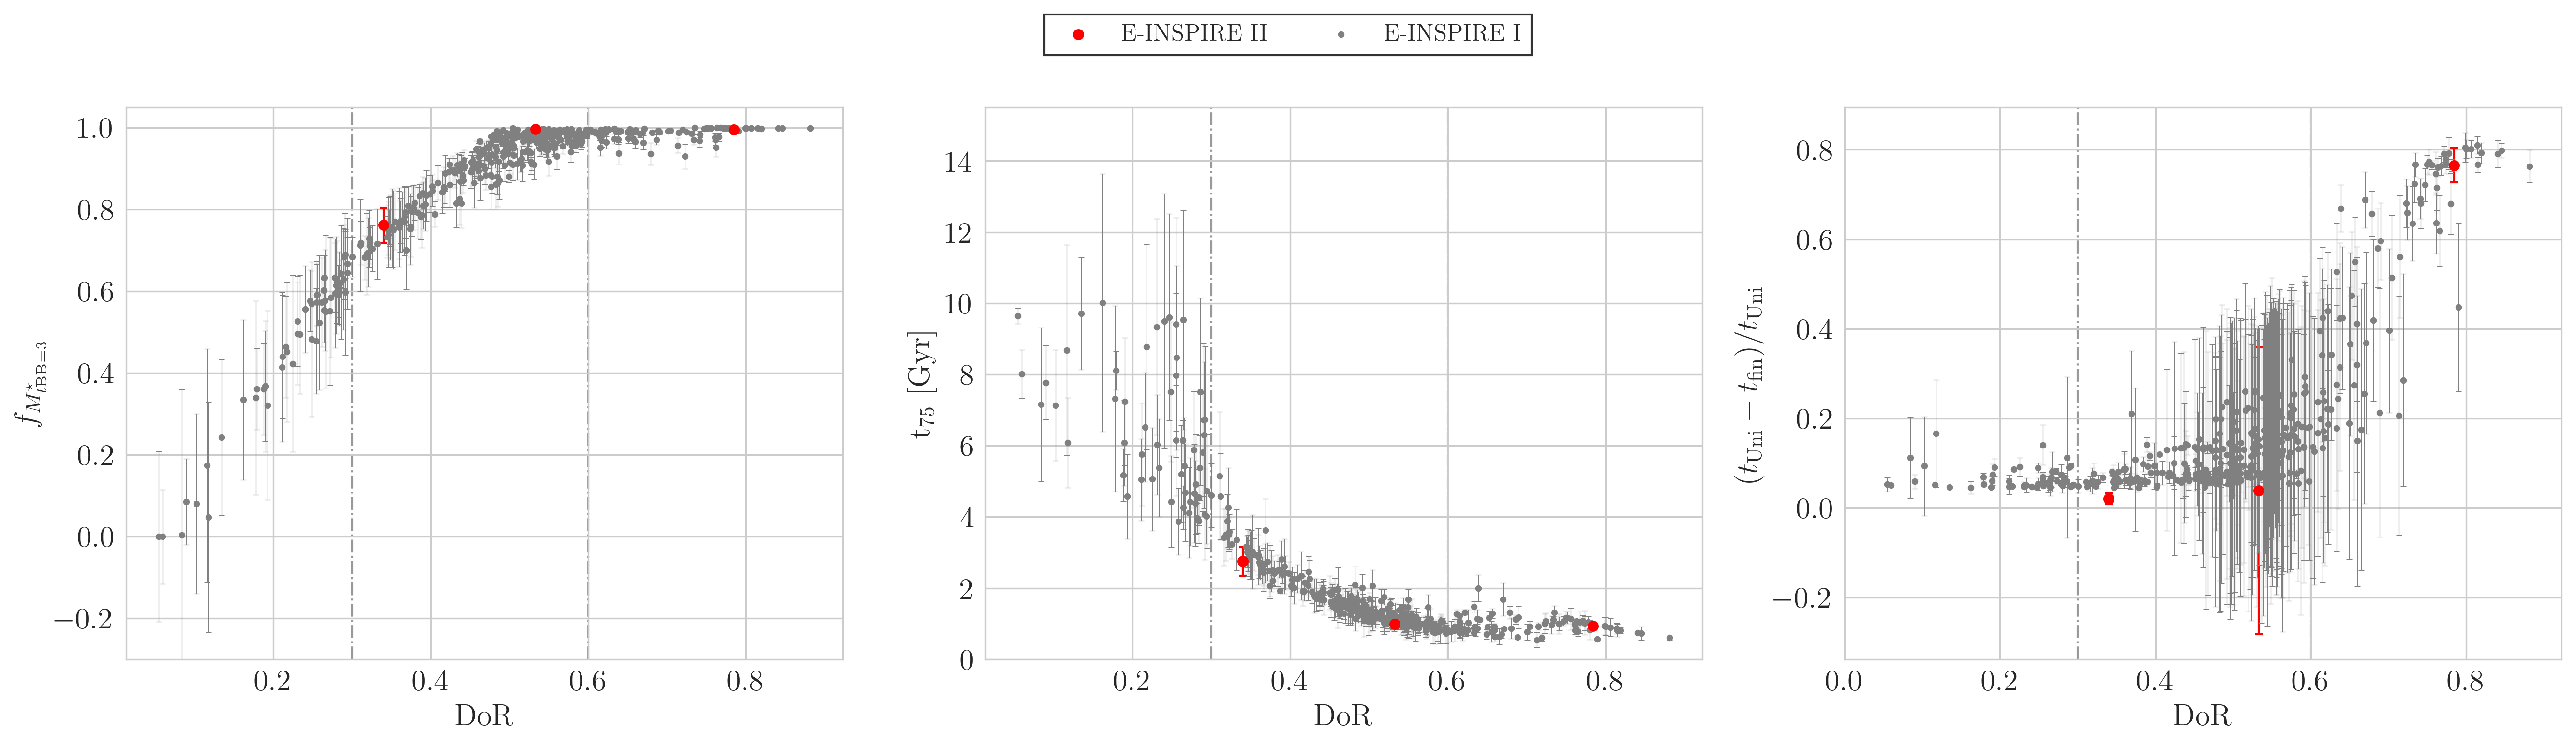

In [23]:
# fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 12))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# fig.subplots_adjust(hspace=0.01)

# Create a mask for E-INSPIRE II and E-INSPIRE I data points
mask_einspire_ii = df['source'] == 'E-INSPIRE II'
mask_einspire_i = df['source'] == 'E-INSPIRE I'

# First subplot - mass fraction
axs[0].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0].set_ylim(top=1.05, bottom=-0.3)

# Calculate errors
err_mass_frac = np.nanstd([df['mass_frac_reg'].values, df['mass_frac_unr'].values, df['mass_frac_plus'], df['mass_frac_min']], axis=0)

# Plot E-INSPIRE II (in red)
axs[0].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'mass_frac'], 
                yerr=err_mass_frac[mask_einspire_ii], fmt='none', c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[0].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'mass_frac'], 
               s=25, c='red', marker='o', linewidths=0.5, label='E-INSPIRE II', zorder=10)

# Plot E-INSPIRE I (in black)
axs[0].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'mass_frac'], 
                yerr=err_mass_frac[mask_einspire_i], fmt='none', c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[0].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'mass_frac'], 
               s=5, c='grey', label='E-INSPIRE I')

axs[0].set_xlabel('DoR')
axs[0].set_ylabel(r'$f_{M^{\star}_{t\mathrm{BB}=3}}$')
axs[0].minorticks_on()
axs[0].tick_params(axis='both',which='major',direction='inout')
axs[0].tick_params(axis='both',which='minor',direction='in')

# Second subplot - time_75
axs[1].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[1].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[1].set_ylim(top=15.5, bottom=0)

# Calculate errors
err_time_75 = np.nanstd([df['time_75_reg'].values, df['time_75_unr'].values, df['time_75_plus'], df['time_75_min']], axis=0)

# Plot E-INSPIRE II (in red)
axs[1].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'time_75'], 
                yerr=err_time_75[mask_einspire_ii], fmt='none', c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[1].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'time_75'], 
               s=25, c='red', marker='o', linewidths=0.5, zorder=10)

# Plot E-INSPIRE I (in black)
axs[1].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'time_75'], 
                yerr=err_time_75[mask_einspire_i], fmt='none', c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[1].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'time_75'], 
               s=5, c='grey')

axs[1].set_xlabel('DoR')
axs[1].set_ylabel(r't$_{75}$ [Gyr]')
axs[1].minorticks_on()
axs[1].tick_params(axis='both',which='major',direction='inout')
axs[1].tick_params(axis='both',which='minor',direction='in')

# Third subplot - universe age calculation
axs[2].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[2].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)

# Calculate the ratio values
ratio_values = (np.array(df['univ_age'])-np.array(df['time_100']))/np.array(df['univ_age'])
#ratio_values = np.array(df['time_100'])

# Plot E-INSPIRE II (in red)
axs[2].errorbar(df.loc[mask_einspire_ii, 'dor'], ratio_values[mask_einspire_ii], 
                fmt='none', yerr=df.loc[mask_einspire_ii, 't_ass_err'], c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[2].scatter(df.loc[mask_einspire_ii, 'dor'], ratio_values[mask_einspire_ii], 
               s=25, c='red', marker='o', linewidths=0.5, zorder=10)

# Plot E-INSPIRE I (in black)
axs[2].errorbar(df.loc[mask_einspire_i, 'dor'], ratio_values[mask_einspire_i], 
                fmt='none', yerr=df.loc[mask_einspire_i, 't_ass_err'], c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[2].scatter(df.loc[mask_einspire_i, 'dor'], ratio_values[mask_einspire_i], 
               s=5, c='grey')

axs[2].set_xlabel('DoR')
axs[2].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axs[2].set_ylabel(r'$(t_{\mathrm{Uni}} - t_{\mathrm{fin}})/t_{\mathrm{Uni}}$')
axs[2].minorticks_on()
axs[2].tick_params(axis='both',which='major',direction='inout')
axs[2].tick_params(axis='both',which='minor',direction='in')

# Add legend at the top of the figure
plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12, fancybox=False, edgecolor='black')

# Optional: Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

## Figure 11


In [24]:
df_me = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_john = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')  # Assuming this is your second dataframe

['ra', 'dec', 'deVRad_r', 'deVRadErr_r', 'expRad_r', 'expRadErr_r', 'z', 'zErr', 'velDisp', 'velDispErr', 'logM', 'errlogM', 'logSFR', 'errlogSFR', 'logsSFR', 'errlogsSFR', 'petroR50Errkpc_r', 'petroR50kpc_r', 'deVRadkpc_r', 'deVRadErrkpc_r', 'expRadkpc_r', 'expRadErrkpc_r', 'fracDev_r', 'meanRadkpc_r', 'plate', 'mjd', 'fiberid', 'velDisp_ppxf', 'Mgb', 'Fe_avg', 'Mgb_corr', 'Fe_avg_corr', 'alpha', 'alpha_flag', 'sexa_id', 'objid', 'logAge_boot', '[M/H]_boot', 'SNR', 'mass_frac', 'time_75', 'time_90', 'time_100', 'dor_100', 'univ_age', 'mass_frac_reg', 'time_75_reg', 'time_90_reg', 'time_100_reg', 'dor_100_reg', 'mass_frac_unr', 'time_75_unr', 'time_90_unr', 'time_100_unr', 'dor_100_unr', 'mass_frac_plus', 'time_75_plus', 'time_90_plus', 'time_100_plus', 'dor_100_plus', 'mass_frac_min', 'time_75_min', 'time_90_min', 'time_100_min', 'dor_100_min', 'dor', 'velDisp_ppxf_err', 'velDisp_ppxf_res', 'velDisp_ppxf_err_res', 'meanRadErrkpc_r', 'meanRad_r', 'meanRadErr_r', 'logAge_noboot', '[M/H]

In [28]:
'''# Load both dataframes
df_me = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_john = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')  # Assuming this is your second dataframe

# Rename columns in df_john to match df_me if needed
# This is just an example - you'll need to adjust based on your actual column names
column_mapping = {
    # df_john column name: df_me column name
    'velDisp_ppxf': 'vel_disp_avg',
    'velDisp_ppxf_err': 'vel_disp_err',
    
}

# Rename columns in df_john
df_john = df_john.rename(columns=column_mapping)
df_john['age_mean'] = 10**df_john['logAge_mean']

# Process df_me
df_me['age_mean'] = 10**df_me['logAge']
df_me['age_min'] = 10**df_me['logAge_minus']
df_me['age_plus'] = 10**df_me['logAge_plus']

df_me['age_err_lower'] = abs(df_me['age_mean'] - df_me['age_min'])
df_me['age_err_upper'] = abs(df_me['age_plus'] - df_me['age_mean'])
df_me['age_err'] = (df_me['age_err_lower'] + df_me['age_err_upper']) / 2

df_me['[M/H]_mean'] = df_me['[M/H]']
df_me['[M/H]_err_lower'] = abs(df_me['[M/H]_mean'] - df_me['[M/H]_minus'])
df_me['[M/H]_err_upper'] = abs(df_me['[M/H]_plus'] - df_me['[M/H]_mean'])
df_me['[M/H]_err'] = (df_me['[M/H]_err_lower'] + df_me['[M/H]_err_upper']) / 2


df_me['source'] = 'E-INSPIRE II'
df_john['source'] = 'E-INSPIRE I'

# Combine the dataframes
# Use only columns that exist in both dataframes
common_columns = list(set(df_me.columns).intersection(set(df_john.columns)))
df_me_subset = df_me[common_columns]
df_john_subset = df_john[common_columns]
df = pd.concat([df_me_subset, df_john_subset], ignore_index=True)

# Create masks for plotting
mask_einspire_ii = df['source'] == 'E-INSPIRE II'
mask_einspire_i = df['source'] == 'E-INSPIRE I'

# Create the figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# First subplot: Velocity dispersion
# Plot E-INSPIRE I (grey) points first
axs[0, 0].errorbar(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'vel_disp_avg']), 
                  yerr=(df.loc[mask_einspire_i, 'vel_disp_err']/df.loc[mask_einspire_i, 'vel_disp_avg'])/np.log(10), 
                  fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[0, 0].scatter(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'vel_disp_avg']), 
                 s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[0, 0].errorbar(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'vel_disp_avg']), 
                  yerr=(df.loc[mask_einspire_ii, 'vel_disp_err']/df.loc[mask_einspire_ii, 'vel_disp_avg'])/np.log(10), 
                  fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[0, 0].scatter(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'vel_disp_avg']), 
                 s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[0, 0].set_xlabel('DoR')
axs[0, 0].set_ylabel(r'$\log(\sigma_{\star}$ [km/s])')
axs[0, 0].minorticks_on()
axs[0, 0].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Second subplot: Stellar age
# Plot E-INSPIRE I (grey) points first
axs[0, 1].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'age_mean'], 
                  yerr=df.loc[mask_einspire_i, 'age_err'], 
                  fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[0, 1].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'age_mean'], 
                 s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[0, 1].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'age_mean'], 
                  yerr=df.loc[mask_einspire_ii, 'age_err'], 
                  fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[0, 1].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'age_mean'], 
                 s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[0, 1].set_xlabel('DoR')
axs[0, 1].set_ylabel('Stellar age [Gyr]')
axs[0, 1].minorticks_on()
axs[0, 1].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Third subplot: Metallicity
# Plot E-INSPIRE I (grey) points first
axs[0, 2].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, '[M/H]_mean'], 
                  yerr=df.loc[mask_einspire_i, '[M/H]_err'], 
                  fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[0, 2].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, '[M/H]_mean'], 
                 s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[0, 2].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, '[M/H]_mean'], 
                  yerr=df.loc[mask_einspire_ii, '[M/H]_err'], 
                  fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[0, 2].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, '[M/H]_mean'], 
                 s=30, c='red', marker='o',linewidths=0.7, zorder=10)

axs[0, 2].set_xlabel('DoR')
axs[0, 2].set_ylabel('[M/H]')
axs[0, 2].minorticks_on()
axs[0, 2].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Fourth subplot: Stellar mass
# Plot E-INSPIRE I (grey) points first
axs[1, 0].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'logM'], 
                  yerr=df.loc[mask_einspire_i, 'errlogM'], 
                  fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1, 0].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'logM'], 
                 s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1, 0].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'logM'], 
                  yerr=df.loc[mask_einspire_ii, 'errlogM'], 
                  fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1, 0].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'logM'], 
                 s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1, 0].set_xlabel('DoR')
axs[1, 0].set_ylabel(r'$\log(\rm M_{\star}\,[\rm M_{\odot}])$')
axs[1, 0].minorticks_on()
axs[1, 0].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Fifth subplot: Effective radius
# Plot E-INSPIRE I (grey) points first
axs[1, 1].errorbar(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'meanRadkpc_r']), 
                  yerr=(df.loc[mask_einspire_i, 'meanRadErrkpc_r']/df.loc[mask_einspire_i, 'meanRadkpc_r'])/np.log(10), 
                  fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1, 1].scatter(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'meanRadkpc_r']), 
                 s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1, 1].errorbar(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'meanRadkpc_r']), 
                  yerr=(df.loc[mask_einspire_ii, 'meanRadErrkpc_r']/df.loc[mask_einspire_ii, 'meanRadkpc_r'])/np.log(10), 
                  fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1, 1].scatter(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'meanRadkpc_r']), 
                 s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1, 1].set_xlabel('DoR')
axs[1, 1].set_ylabel(r'$\log(\rm R_e$ [kpc])')
axs[1, 1].minorticks_on()
axs[1, 1].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Sixth subplot: sSFR
# Plot E-INSPIRE I (grey) points first
axs[1, 2].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'logsSFR'], 
                  yerr=df.loc[mask_einspire_i, 'errlogsSFR'], 
                  fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1, 2].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'logsSFR'], 
                 s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1, 2].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'logsSFR'], 
                  yerr=df.loc[mask_einspire_ii, 'errlogsSFR'], 
                  fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1, 2].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'logsSFR'], 
                 s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1, 2].set_xlabel('DoR')
axs[1, 2].set_ylabel(r'$\log(\rm sSFR~[yr^{-1}])$')
axs[1, 2].minorticks_on()
axs[1, 2].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Add a legend to the figure
# Create custom handles for the legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
             markersize=10, label='E-INSPIRE II'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', 
           markersize=5, label='E-INSPIRE I')
]
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.01), ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])'''

print("SkipME")
# This is the version with all 6 graphs

SkipME


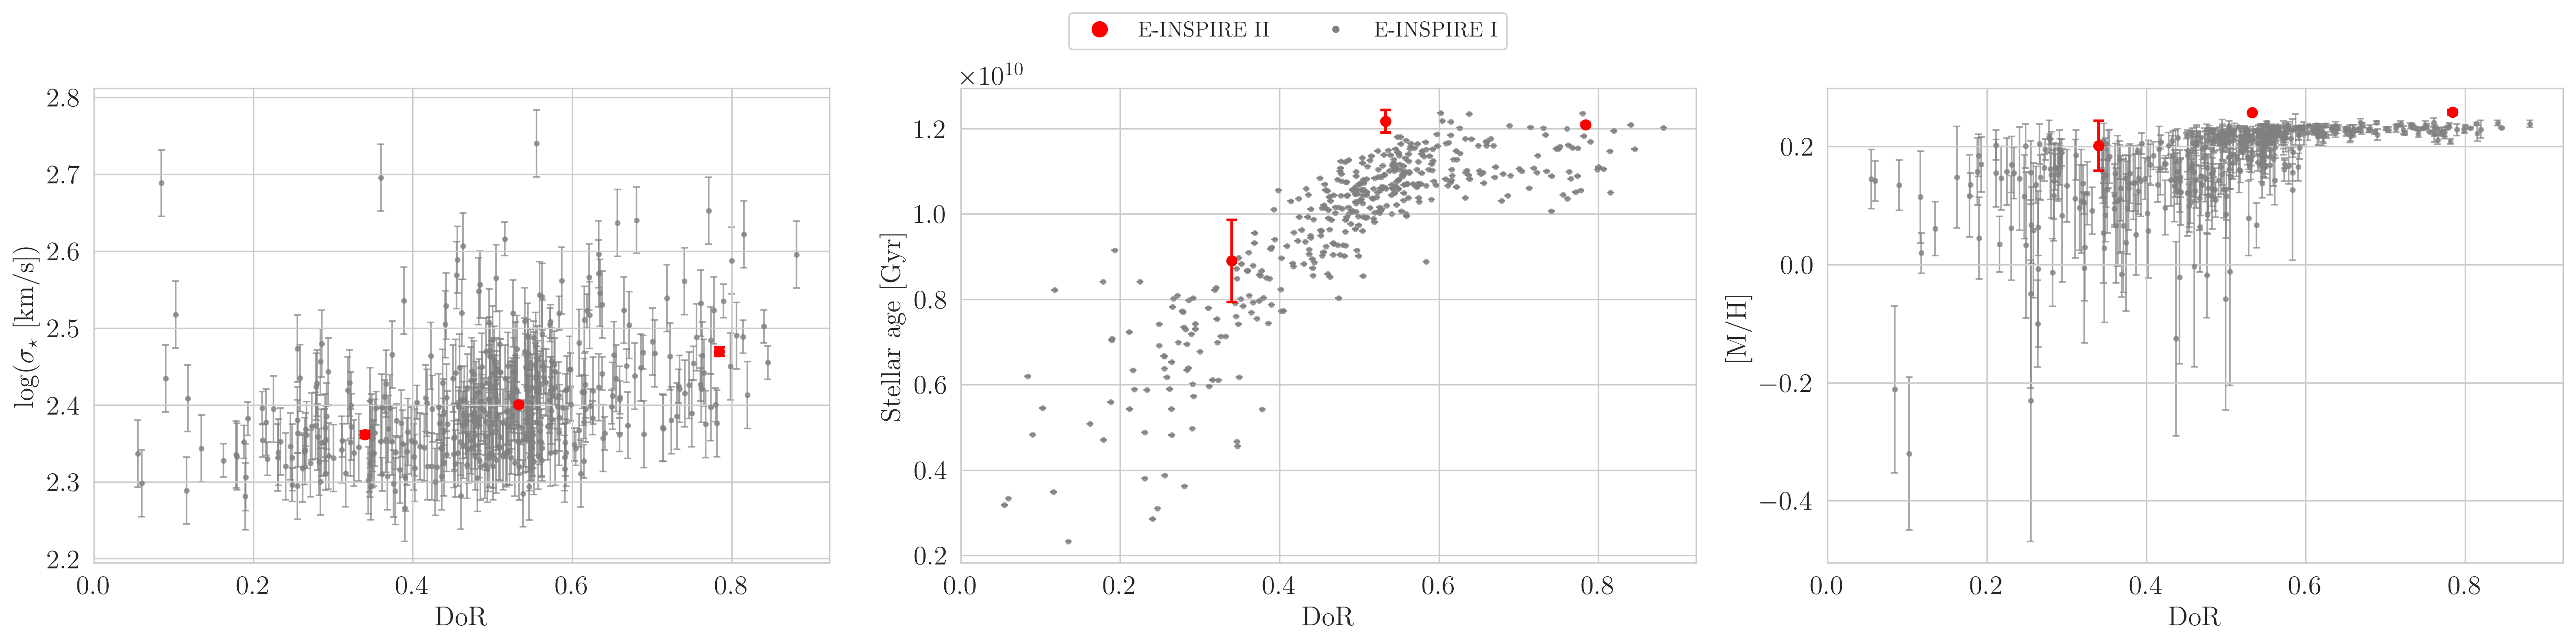

In [26]:
# Version with only top row
df_me = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_john = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')  # Assuming this is your second dataframe

# Rename columns in df_john to match df_me if needed
# This is just an example - you'll need to adjust based on your actual column names
column_mapping = {
    # df_john column name: df_me column name
    'velDisp_ppxf': 'vel_disp_avg',
    'velDisp_ppxf_err': 'vel_disp_err',
    
}

# Rename columns in df_john
df_john = df_john.rename(columns=column_mapping)
df_john['age_mean'] = 10**df_john['logAge_mean']

# Process df_me
df_me['age_mean'] = 10**df_me['logAge']
df_me['age_min'] = 10**df_me['logAge_minus']
df_me['age_plus'] = 10**df_me['logAge_plus']

df_me['age_err_lower'] = abs(df_me['age_mean'] - df_me['age_min'])
df_me['age_err_upper'] = abs(df_me['age_plus'] - df_me['age_mean'])
df_me['age_err'] = (df_me['age_err_lower'] + df_me['age_err_upper']) / 2

df_me['[M/H]_mean'] = df_me['[M/H]']
df_me['[M/H]_err_lower'] = abs(df_me['[M/H]_mean'] - df_me['[M/H]_minus'])
df_me['[M/H]_err_upper'] = abs(df_me['[M/H]_plus'] - df_me['[M/H]_mean'])
df_me['[M/H]_err'] = (df_me['[M/H]_err_lower'] + df_me['[M/H]_err_upper']) / 2


df_me['source'] = 'E-INSPIRE II'
df_john['source'] = 'E-INSPIRE I'

# Combine the dataframes
# Use only columns that exist in both dataframes
common_columns = list(set(df_me.columns).intersection(set(df_john.columns)))
df_me_subset = df_me[common_columns]
df_john_subset = df_john[common_columns]
df = pd.concat([df_me_subset, df_john_subset], ignore_index=True)

# Create masks for plotting
mask_einspire_ii = df['source'] == 'E-INSPIRE II'
mask_einspire_i = df['source'] == 'E-INSPIRE I'

# Create the figure and subplots - modified to only have 1 row with 3 columns
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# First subplot: Velocity dispersion
# Plot E-INSPIRE I (grey) points first
axs[0].errorbar(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'vel_disp_avg']), 
                yerr=(df.loc[mask_einspire_i, 'vel_disp_err']/df.loc[mask_einspire_i, 'vel_disp_avg'])/np.log(10), 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[0].scatter(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'vel_disp_avg']), 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[0].errorbar(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'vel_disp_avg']), 
                yerr=(df.loc[mask_einspire_ii, 'vel_disp_err']/df.loc[mask_einspire_ii, 'vel_disp_avg'])/np.log(10), 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[0].scatter(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'vel_disp_avg']), 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[0].set_xlabel('DoR')
axs[0].set_ylabel(r'$\log(\sigma_{\star}$ [km/s])')
axs[0].minorticks_on()
axs[0].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Second subplot: Stellar age
# Plot E-INSPIRE I (grey) points first
axs[1].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'age_mean'], 
                yerr=df.loc[mask_einspire_i, 'age_err'], 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'age_mean'], 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'age_mean'], 
                yerr=df.loc[mask_einspire_ii, 'age_err'], 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'age_mean'], 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1].set_xlabel('DoR')
axs[1].set_ylabel('Stellar age [Gyr]')
axs[1].minorticks_on()
axs[1].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Third subplot: Metallicity
# Plot E-INSPIRE I (grey) points first
axs[2].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, '[M/H]_mean'], 
                yerr=df.loc[mask_einspire_i, '[M/H]_err'], 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[2].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, '[M/H]_mean'], 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[2].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, '[M/H]_mean'], 
                yerr=df.loc[mask_einspire_ii, '[M/H]_err'], 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[2].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, '[M/H]_mean'], 
              s=30, c='red', marker='o',linewidths=0.7, zorder=10)

axs[2].set_xlabel('DoR')
axs[2].set_ylabel('[M/H]')
axs[2].minorticks_on()
axs[2].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
             markersize=10, label='E-INSPIRE II'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', 
           markersize=5, label='E-INSPIRE I')
]
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.01), ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])

## Figure 13

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_9861/59834036.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mass_bin'] = pd.cut(df1['logM'], bins=bins)
/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_9861/59834036.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['mass_bin'] = pd.cut(df2['logM'], bins=bins)
/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_9861/59834036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Index(['logAge', '[M/H]', 'SNR', 'mass_frac', 'time_75', 'time_90', 'time_100',
       'dor_100', 'univ_age', 'mass_frac_reg', 'time_75_reg', 'time_90_reg',
       'time_100_reg', 'dor_100_reg', 'mass_frac_unr', 'time_75_unr',
       'time_90_unr', 'time_100_unr', 'dor_100_unr', 'logAge_plus',
       '[M/H]_plus', 'SNR_plus', 'mass_frac_plus', 'time_75_plus',
       'time_90_plus', 'time_100_plus', 'dor_100_plus', 'logAge_minus',
       '[M/H]_minus', 'SNR_minus', 'mass_frac_min', 'time_75_min',
       'time_90_min', 'time_100_min', 'dor_100_min', 'alpha_flag',
       'vel_disp_avg', 'vel_disp_err', 'vel_disp_max', 'alpha', 'filename',
       'logM', 'errlogM', 'meanRadkpc_r', 'meanRadErrkpc_r', 'dor',
       '[M/H]_mean', '[M/H]_err_lower', '[M/H]_err_upper', '[M/H]_err'],
      dtype='object')


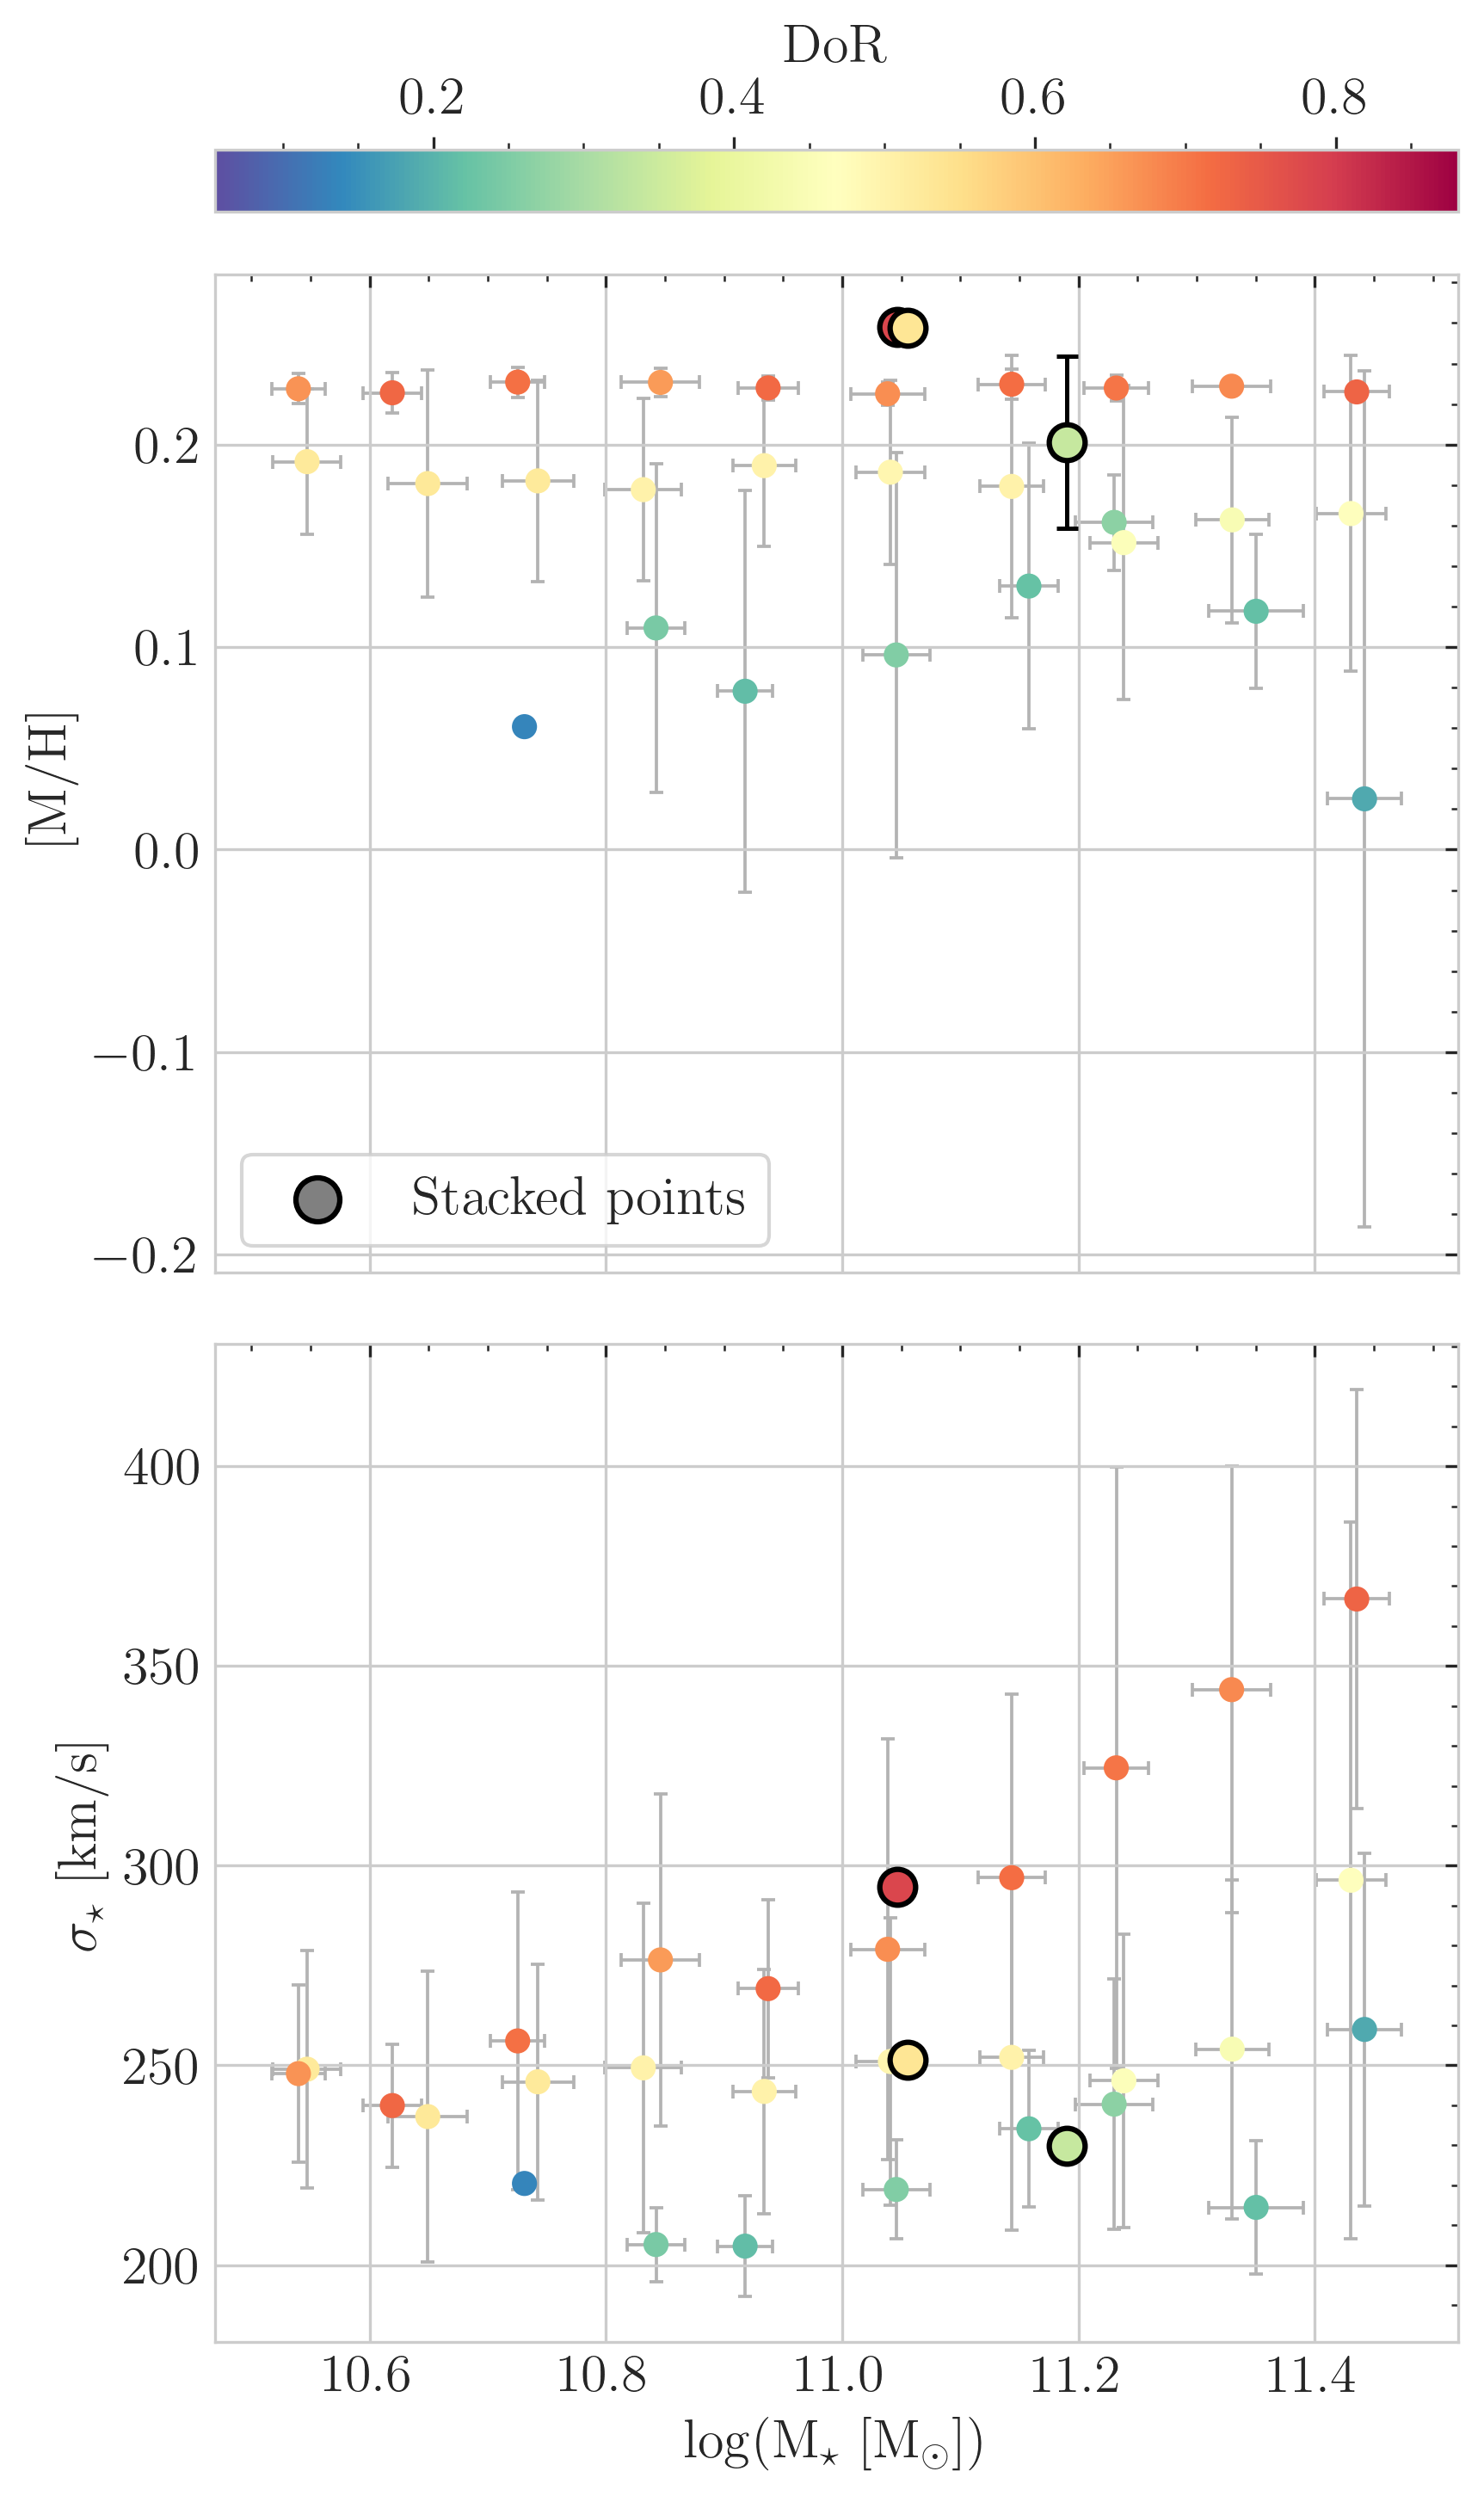

In [27]:
custom_df = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
custom_df['[M/H]_mean'] = custom_df['[M/H]']
custom_df['[M/H]_err_lower'] = abs(custom_df['[M/H]_mean'] - custom_df['[M/H]_minus'])
custom_df['[M/H]_err_upper'] = abs(custom_df['[M/H]_plus'] - custom_df['[M/H]_mean'])
custom_df['[M/H]_err'] = (custom_df['[M/H]_err_lower'] + custom_df['[M/H]_err_upper']) / 2

print(custom_df.columns)

custom_df = custom_df.sort_values(by='logM')
custom_df = custom_df.rename(columns={
    #'[M/H]': '[M/H]_mean',
    'vel_disp_avg': 'velDisp_ppxf'
})

df = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')
df1 = df[df['dor'] <= 0.3]
df2 = df[(df['dor'] > 0.3) & (df['dor'] <= 0.6)]
df3 = df[df['dor'] > 0.6]

# Define the bin edges
bins = np.arange(df['logM'].min(), df['logM'].max(), 0.1)

# Create new columns in each dataframe with the bin labels
df1['mass_bin'] = pd.cut(df1['logM'], bins=bins)
df2['mass_bin'] = pd.cut(df2['logM'], bins=bins)
df3['mass_bin'] = pd.cut(df3['logM'], bins=bins)
df1_grouped = df1.groupby('mass_bin')[['[M/H]_mean', 'dor', 'logM']].agg(['mean', 'std'])
df2_grouped = df2.groupby('mass_bin')[['[M/H]_mean', 'dor', 'logM']].agg(['mean', 'std'])
df3_grouped = df3.groupby('mass_bin')[['[M/H]_mean', 'dor', 'logM']].agg(['mean', 'std'])

# For each dataframe, group by mass_bin and compute mean and std
df1_groupeda = df1.groupby('mass_bin')[['velDisp_ppxf', 'dor', 'logM']].agg(['mean', 'std'])
df2_groupeda = df2.groupby('mass_bin')[['velDisp_ppxf', 'dor', 'logM']].agg(['mean', 'std'])
df3_groupeda = df3.groupby('mass_bin')[['velDisp_ppxf', 'dor', 'logM']].agg(['mean', 'std'])

# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(6,10), sharex=True, height_ratios=[1.25, 1])
fig.subplots_adjust(hspace=0.01)
cmap = plt.get_cmap('Spectral_r')
norm = plt.Normalize(df['dor'].min(), df['dor'].max())

# Plot existing grouped data
axs[0].errorbar(df1_grouped['logM']['mean'], df1_grouped['[M/H]_mean']['mean'], xerr=df1_grouped['logM']['std'], yerr=df1_grouped['[M/H]_mean']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[0].errorbar(df2_grouped['logM']['mean'], df2_grouped['[M/H]_mean']['mean'], xerr=df2_grouped['logM']['std'], yerr=df2_grouped['[M/H]_mean']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[0].errorbar(df3_grouped['logM']['mean'], df3_grouped['[M/H]_mean']['mean'], xerr=df3_grouped['logM']['std'], yerr=df3_grouped['[M/H]_mean']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[0].scatter(df1_grouped['logM']['mean'], df1_grouped['[M/H]_mean']['mean'], c=cmap(norm(df1_grouped['dor']['mean'])))
axs[0].scatter(df2_grouped['logM']['mean'], df2_grouped['[M/H]_mean']['mean'], c=cmap(norm(df2_grouped['dor']['mean'])))
axs[0].scatter(df3_grouped['logM']['mean'], df3_grouped['[M/H]_mean']['mean'], c=cmap(norm(df3_grouped['dor']['mean'])))

axs[1].errorbar(df1_groupeda['logM']['mean'], df1_groupeda['velDisp_ppxf']['mean'], xerr=df1_groupeda['logM']['std'], yerr=df1_groupeda['velDisp_ppxf']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[1].errorbar(df2_groupeda['logM']['mean'], df2_groupeda['velDisp_ppxf']['mean'], xerr=df2_groupeda['logM']['std'], yerr=df2_groupeda['velDisp_ppxf']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[1].errorbar(df3_groupeda['logM']['mean'], df3_groupeda['velDisp_ppxf']['mean'], xerr=df3_groupeda['logM']['std'], yerr=df3_groupeda['velDisp_ppxf']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[1].scatter(df1_groupeda['logM']['mean'], df1_groupeda['velDisp_ppxf']['mean'], c=cmap(norm(df1_groupeda['dor']['mean'])))
axs[1].scatter(df2_groupeda['logM']['mean'], df2_groupeda['velDisp_ppxf']['mean'], c=cmap(norm(df2_groupeda['dor']['mean'])))
axs[1].scatter(df3_groupeda['logM']['mean'], df3_groupeda['velDisp_ppxf']['mean'], c=cmap(norm(df3_groupeda['dor']['mean'])))

# Plot the custom points from CATALOGUE_REGRESSION.csv with error bars
custom_points = custom_df.head(3)  # Get the first 3 rows
for _, point in custom_points.iterrows():
    # If 'dor' is not in the custom dataframe, assign a default value or create a formula
    if 'dor' not in custom_df.columns:
        dor_value = 0.5  # Default middle value, or choose appropriate value
    else:
        dor_value = point['dor']
    
    # First plot error bars for metallicity panel (upper)
    axs[0].errorbar(
        point['logM'], 
        point['[M/H]_mean'], 
        xerr=point['errlogM'] if 'errlogM' in point else None,
        yerr=point['[M/H]_err'] if '[M/H]_err' in point else None,
        fmt='none', 
        ecolor='black',
        capsize=3,
        elinewidth=1.2,
        capthick=1.2,
        zorder=9
    )
    
    # Then plot error bars for velocity dispersion panel (lower)
    axs[1].errorbar(
        point['logM'], 
        point['velDisp_ppxf'], 
        xerr=point['errlogM'] if 'errlogM' in point else None,
        yerr=point['vel_disp_err'] if 'vel_disp_err' in point else None,
        fmt='none', 
        ecolor='black',
        capsize=3,
        elinewidth=1.2,
        capthick=1.2,
        zorder=9
    )
    
    # Plot the actual points on top of error bars
    # Plot in the metallicity panel (upper)
    axs[0].scatter(point['logM'], point['[M/H]_mean'], c=cmap(norm(dor_value)), 
                  marker='o', s=100, edgecolor='black', linewidth=1.5, zorder=10)
    
    # Plot in the velocity dispersion panel (lower)
    axs[1].scatter(point['logM'], point['velDisp_ppxf'], c=cmap(norm(dor_value)),
                  marker='o', s=100, edgecolor='black', linewidth=1.5, zorder=10)

# Add a legend for the custom points
axs[0].scatter([], [], c='gray', marker='o', s=150, edgecolor='black', linewidth=1.5, label='Stacked points')
axs[0].legend(loc='best')

axs[0].set_ylabel(r'[M/H]')
axs[0].minorticks_on()
axs[0].tick_params(axis='both',which='both',direction='in', right=True, top=True)

axs[1].set_xlabel(r'$\log(\rm M_{\star}$ $\rm [M_{\odot}])$')
axs[1].set_ylabel(r'$\sigma_{\star}$ [km/s]')
axs[1].minorticks_on()
axs[1].tick_params(axis='both',which='both',direction='in', right=True, top=True)

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], label='DoR', location='top')
cb.minorticks_on()

plt.tight_layout()
plt.savefig('mass_metallicity_velocity_with_stacked_points.pdf', bbox_inches='tight')
plt.show()